In [814]:
# the libraries we need
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from  sklearn.preprocessing import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import loguniform
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
import scikitplot as skplt
from nba_predictions.utilities.support import shuffle_dataset, load_data, get_features_labels_from_df, print_model_metrics
from nba_predictions.utilities.data_processing import get_robust_scaled_data
from sklearn.model_selection import cross_val_score
import nba_predictions.utilities.plot_utilities as plot_utilities
sns.set()

## Load Dataset
Load the nba 10 recent perfomances dataset and divide features and labels

In [815]:
nba_df = load_data('../datasets/final_data/nba_10_recent_perfomance_test.csv', 'GAME_DATE', 'WINNER')

In [816]:
nba_df = shuffle_dataset(nba_df)

In [817]:
cols_to_delete = ['GAME_DATE', 'GAME_ID', 'H_NAME', 'A_NAME', 'SEASON', 'WINNER']
features, labels = get_features_labels_from_df(nba_df, cols_to_delete, 'WINNER')
features, X_test, labels, y_test = train_test_split(features, labels, test_size=0.20, random_state=42,
                                                    shuffle=True)

## Apply a RobustScaler to the features
Scale features using statistics that are robust to *outliers*.

In [818]:
#features_scaled = get_robust_scaled_data(features)
robust_scaler = RobustScaler(with_scaling=True, with_centering=True)
robust_scaler.fit(features)
features_scaled=  pd.DataFrame(robust_scaler.transform(features), columns=features.columns, index=features.index)

Transform with robust scaler also the test data that we use at the end of project

In [819]:
X_test = pd.DataFrame(robust_scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

## Balance the dataset with SMOTE and TOMEK-LiNK

In [820]:
from imblearn.combine import SMOTETomek
# transform the dataset
oversample = SMOTETomek(random_state=42, n_jobs=-1)
features_scaled, labels = oversample.fit_resample(features_scaled, labels)

<Figure size 2304x1728 with 0 Axes>

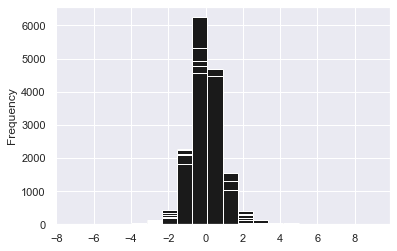

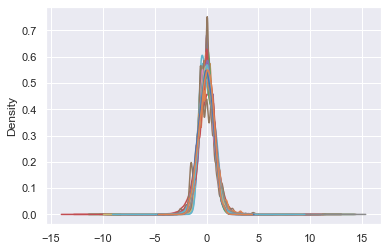

In [821]:
plot_utilities.plot_data_distribution(features_scaled)

In [822]:
features_scaled

,PTS_away_avg,FG_PCT_away_avg,FT_PCT_away_avg,FG3_PCT_away_avg,AST_away_avg,REB_away_avg,FGM_away_avg,FGA_away_avg,FG3M_away_avg,FG3A_away_avg,...,EFFICACY_home_avg,EFG_home_avg,PTS_FGA_home_avg,PIE_home_avg,POSS_home_avg,PACE_home_avg,OFF_EFC_home_avg,DEF_EFC_home_avg,ELO_BEFORE_home,ELO_BEFORE_away
0,0.415315,-1.000000,0.166667,-0.250000,0.000000,0.675676,0.384615,1.037500,0.485714,0.436782,...,0.543689,0.200000,0.800000,-0.185897,-0.476643,0.337531,0.075000,2.280488,-0.641627,-1.045057
1,0.036036,-1.333333,0.000000,-0.750000,-1.111111,0.054054,-0.128205,0.078125,-0.371429,-0.425287,...,1.029126,0.400000,0.100000,1.038462,0.367379,0.088161,0.000000,-1.439024,0.850458,-0.022731
2,1.585586,0.333333,0.333333,0.000000,0.555556,0.405405,0.897436,0.703125,1.142857,1.183908,...,1.679612,1.600000,1.600000,1.871795,1.165479,0.609572,1.625000,0.365854,0.186626,-0.962695
3,-0.666667,-1.333333,-0.666667,-1.750000,-0.833333,0.000000,-0.794872,-0.156250,-0.742857,-0.413793,...,-0.572816,0.200000,0.200000,-0.288462,-1.067300,-1.672544,1.812500,-1.548780,0.027093,-0.623982
4,1.207207,0.000000,-0.333333,0.000000,0.833333,0.540541,0.256410,0.000000,1.057143,1.413793,...,0.980583,0.200000,0.100000,0.871795,0.728424,0.711587,0.812500,0.121951,0.187147,-1.062872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12147,-0.613286,-1.282014,0.282014,-0.211510,-0.664549,0.124733,-0.926949,0.165872,0.123062,0.436739,...,0.002580,-0.030792,-0.200000,0.241569,0.042002,0.002583,-0.775971,0.140709,1.797797,1.126911
12148,0.170490,0.949611,-0.062986,1.386625,0.602713,-0.163574,0.650716,-0.957756,0.303488,-0.029270,...,-0.581762,-0.384883,-0.577325,-0.551394,-0.266512,0.579865,-0.470276,-0.219512,-1.025673,-0.166142
12149,-0.241749,-0.333333,-0.325237,0.012144,0.420715,-0.179455,0.000000,0.219195,-0.295668,-0.323052,...,1.013725,-0.209715,-0.290285,0.451628,0.405973,0.141999,-0.181931,-0.341218,0.434129,0.105680
12150,0.272709,0.333333,-0.265764,0.601355,0.009763,0.243250,0.009006,-0.188766,-0.243244,-0.390496,...,-0.823144,-1.081084,-1.181084,-0.705300,-0.499720,-1.139912,-0.294594,-1.124264,-0.272805,-0.488304


## LinearSVC
First, I used a Linear SVC from sklearn to train the model.
To obtain the best hyperparameters I used a RandomizedSearch

In [869]:
from sklearn.calibration import CalibratedClassifierCV
param = {
    "dual" : [False, True],
    "tol" : loguniform(1e-5, 1000),
    "C" : loguniform(1e-5, 1000),
    'penalty' : ['l1', 'l2'],
}
# define model
model = LinearSVC(random_state=42)
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# define search
search = RandomizedSearchCV(model, param, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=42, verbose=0)
# execute search
result = search.fit(features_scaled, labels)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

/Users/biagiolicari/miniforge3/envs/workspace/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/biagiolicari/miniforge3/envs/workspace/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/biagiolicari/miniforge3/envs/workspace/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/biagiolicari/miniforge3/envs/workspace/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/biagiolicari/miniforge3/envs/workspace/lib/python3.10/site-packages/sklearn/svm/_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iteration

Best Score: 0.7318190370136858
Best Hyperparameters: {'C': 0.028546978577971793, 'dual': False, 'penalty': 'l1', 'tol': 0.7849159562555073}


In [ ]:
param = {
    "dual" : [False, True],
    "C" : np.random.uniform(0.01, 0.9, 1000),
    "tol" : np.random.uniform(0.6, .9, 100),
    'loss' : ['hinge', 'squared_hinge'],
    'fit_intercept' : [False, True],
    'penalty' : ['l1', 'l2'],
}

# random search logistic regression model on the sonar dataset
# define model
model = (LinearSVC(random_state=42))
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# define search
search = RandomizedSearchCV(model, param, scoring='accuracy', n_jobs=-1, cv=cv, random_state=42, verbose=0)
# execute search
result = search.fit(features_scaled, labels)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Once obtained the best estimator, it was used with a cross validation score technique with StratifiedKfold to assess the model perfomance indexes

In [882]:
search.best_estimator_

LinearSVC(C=0.2594686288978597, dual=False, fit_intercept=False,
          random_state=42, tol=0.8357856545225774)

Once that Hyperparameter tuning finished, It is time to use cross-validation technique to get a stime of the error of the model. I choose to use a RepeteadStratifiedKFold with 10 fold and 3 repeats.

In [883]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
#LinearSVC(C=0.5599694594681137, dual=False, fit_intercept=False,random_state=42, tol=0.69617831589887)
#LinearSVC(C=0.2594686288978597, dual=False, fit_intercept=False,random_state=42, tol=0.8357856545225774)
linear_svc_model = search.best_estimator_
scores = cross_val_score(linear_svc_model, features_scaled, labels, cv=cv, scoring='accuracy')
print('std: %s' % scores.std())
print('mean: %s' % scores.mean())
print(scores)

std: 0.013289454368443122
mean: 0.6729204344451662
[0.67598684 0.68503289 0.66831276 0.66831276 0.69135802 0.66337449
 0.66419753 0.67407407 0.67325103 0.66584362 0.68421053 0.66694079
 0.64938272 0.66748971 0.68312757 0.66748971 0.70041152 0.67160494
 0.65185185 0.68312757 0.65707237 0.68092105 0.66831276 0.66419753
 0.67407407 0.65761317 0.68312757 0.6872428  0.70534979 0.65432099]


In [874]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
linear_svc_model = search.best_estimator_
scores = cross_val_score(linear_svc_model, features_scaled, labels, cv=cv, scoring='roc_auc')
print('std: %s' % scores.std())
print('mean: %s' % scores.mean())
print(scores)

std: 0.014018338893817378
mean: 0.7320939991479922
[0.72501515 0.75382239 0.71795879 0.72247301 0.74860997 0.71102489
 0.73518653 0.73614302 0.74355382 0.73451184 0.73137227 0.72392767
 0.70706072 0.72885958 0.74209063 0.72685717 0.75015716 0.73636792
 0.72355415 0.75170706 0.71392941 0.74093231 0.73292671 0.70911732
 0.73267472 0.72166013 0.74090111 0.7432666  0.76342615 0.71373179]


### Plot the learning curve

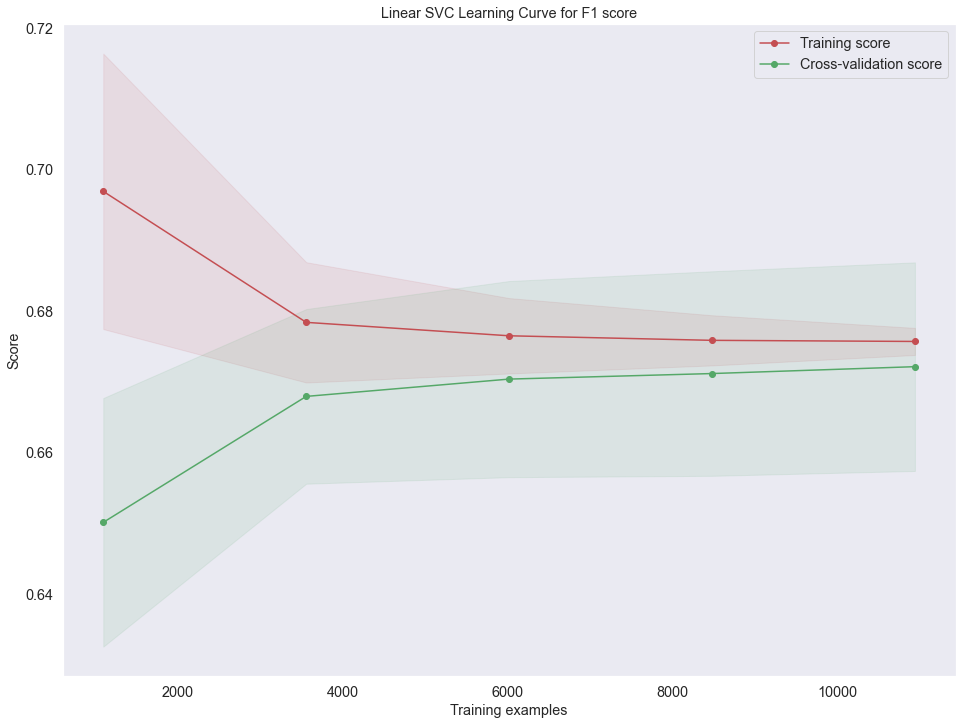

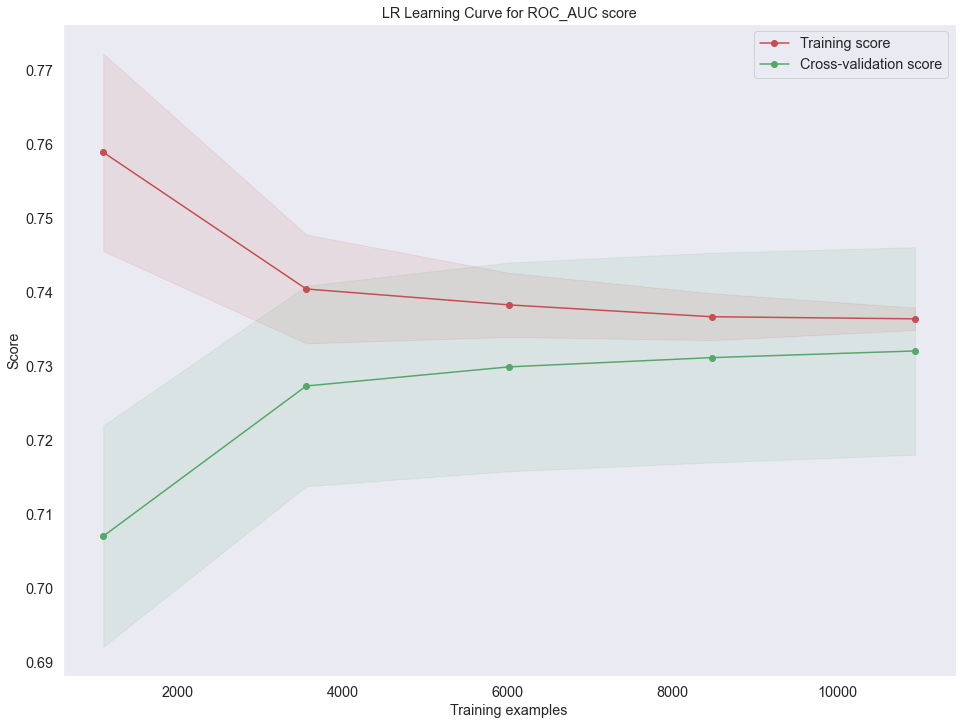

In [875]:
plot_utilities.plot_learning_curve(model=linear_svc_model,
                                   X_train=features_scaled,
                                   y_train=labels,
                                   cv=cv,
                                   scoring='f1',
                                   title="Linear SVC Learning Curve for F1 score")

plot_utilities.plot_learning_curve(model=linear_svc_model,
                                   X_train=features_scaled,
                                   y_train=labels,
                                   cv=cv,
                                   scoring='roc_auc',
                                   title="LR Learning Curve for ROC_AUC score")

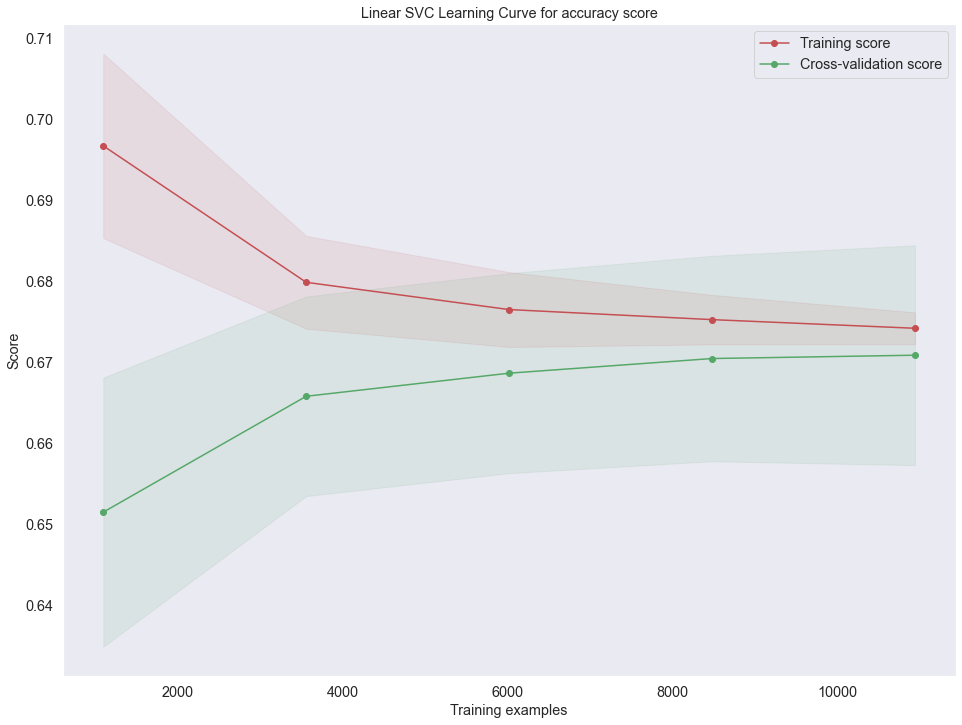

In [876]:
plot_utilities.plot_learning_curve(model=linear_svc_model,
                                   X_train=features_scaled,
                                   y_train=labels,
                                   cv=cv,
                                   scoring='accuracy',
                                   title="Linear SVC Learning Curve for accuracy score")

Once we obtained a final model, It's time to try it on the previous test data doesn't seen from model

In [877]:
from sklearn.calibration import CalibratedClassifierCV
linear_svc_model = CalibratedClassifierCV(linear_svc_model)
linear_svc_model.fit(features_scaled, labels)
linear_svc_pred = pd.DataFrame(linear_svc_model.predict(X_test), index=X_test.index)
linear_svc_pred_prob = pd.DataFrame(linear_svc_model.predict_proba(X_test), index=X_test.index)

In [878]:
print(f'Classification report : \n {metrics.classification_report(y_test, linear_svc_pred)}')

Classification report : 
               precision    recall  f1-score   support

           0       0.56      0.64      0.60      1140
           1       0.73      0.66      0.70      1689

    accuracy                           0.66      2829
   macro avg       0.65      0.65      0.65      2829
weighted avg       0.67      0.66      0.66      2829



In [879]:
print_model_metrics(y_test, linear_svc_pred, linear_svc_pred_prob[1])

F1 Score: 0.7
Accuracy Score: 0.66
AUC Score: 0.698
Precision Score: 0.734
Recall Score: 0.663


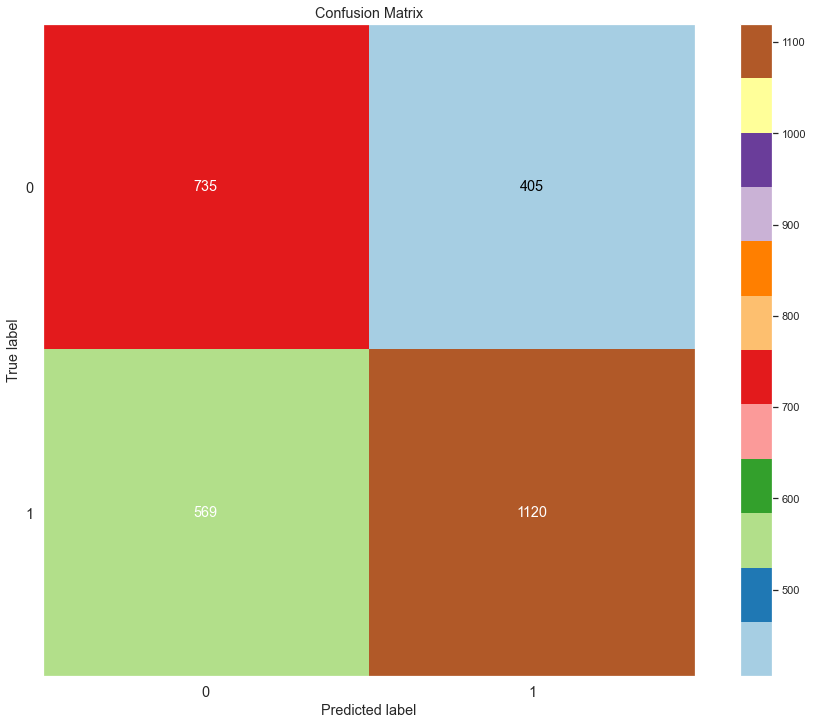

In [880]:
plot_utilities.plot_confusion_matrix(y_test, linear_svc_pred, title='Confusion Matrix')

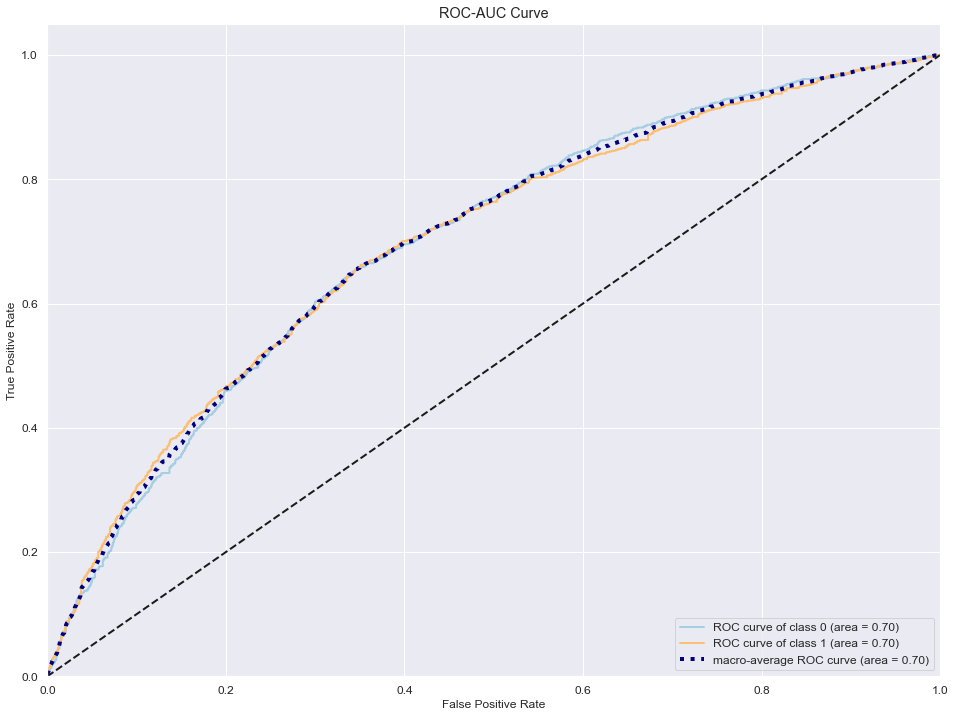

In [890]:
plot_utilities.plot_roc_auc_curve(y_test, linear_svc_pred_prob, 'ROC-AUC Curve')

In [886]:
def get_prediction_df(pred_prob, pred, full_df):
    concat = [pred_prob, pred]
    final_prediction = pd.concat(concat, axis=1, ignore_index=False)
    final_prediction.columns = ['AWAY_WIN_PROBABILITY', 'HOME_WIN_PROBABILITY', 'RESULT_PREDICTION']
    final_prediction['RESULT_PREDICTION'] = final_prediction['RESULT_PREDICTION'].apply(lambda value: 'Away Team Win' if value == 0 else 'Home Team Win')
    final_prediction = pd.merge(full_df.iloc[:, 1:5], final_prediction, left_index=True, right_index=True)
    return final_prediction

final_prediction_nba_log_regr = get_prediction_df(linear_svc_pred_prob, linear_svc_pred, nba_df)
final_prediction_nba_log_regr

,GAME_ID,H_NAME,A_NAME,SEASON,AWAY_WIN_PROBABILITY,HOME_WIN_PROBABILITY,RESULT_PREDICTION
8,21401081,HOU,MIN,2014,0.157789,0.842211,Home Team Win
14,21400636,GSW,HOU,2014,0.291050,0.708950,Home Team Win
15,41800174,UTA,HOU,2018,0.607285,0.392715,Away Team Win
19,21900886,LAC,DEN,2019,0.548126,0.451874,Away Team Win
31,21700263,OKC,GSW,2017,0.779441,0.220559,Away Team Win
...,...,...,...,...,...,...,...
14124,21800321,DET,CHI,2018,0.294169,0.705831,Home Team Win
14126,21100381,NOP,CHI,2011,0.843853,0.156147,Away Team Win
14133,22000790,ORL,IND,2020,0.735742,0.264258,Away Team Win
14137,21801023,TOR,LAL,2018,0.281459,0.718541,Home Team Win


## SUPPORT VECTOR MACHINE

Try to use RandomSearch to get best parameter eg: kernel for the model

In [ ]:
param = {
    'C' : loguniform(1e-5, 100),
    'kernel' : ["rbf", "poly", "sigmoid"]
}

# random search logistic regression model on the sonar dataset
# define model
model = SVC(random_state=42, cache_size=1800)
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# define search
search = RandomizedSearchCV(model, param, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=42, verbose=0)
# execute search
result = search.fit(features_scaled, labels)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

In [850]:
param = {
    'kernel' : ["poly"],
    'gamma' : np.round(np.random.uniform(0.001, 0.1, 30), 3),
    'C' : np.round(np.random.uniform(0.8, 1.5, 10), 4),
    'degree' : [1,2,3]
}

# random search logistic regression model on the sonar dataset
# define model
model = SVC(random_state=42, cache_size=1800)
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# define search
search = RandomizedSearchCV(model, param, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=42, verbose=0, n_iter=4)
# execute search
result = search.fit(features_scaled, labels)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.7311614830585783
Best Hyperparameters: {'kernel': 'poly', 'gamma': 0.015, 'degree': 1, 'C': 1.1725}


In [ ]:
param = {
    'kernel' : ["poly"],
    'gamma' : np.round(np.random.uniform(0.01, 0.08, 30), 3),
    'C' : np.round(np.random.uniform(1.0, 1.3, 10), 4),
    'degree' : [1]
}

# random search logistic regression model on the sonar dataset
# define model
model = SVC(random_state=42, cache_size=1800)
# define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
# define search
search = RandomizedSearchCV(model, param, scoring='roc_auc', n_jobs=-1, cv=cv, random_state=42, verbose=0, n_iter=4)
# execute search
result = search.fit(features_scaled, labels)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

In [851]:
search.best_estimator_

SVC(C=1.1725, cache_size=1800, degree=1, gamma=0.015, kernel='poly',
    random_state=42)

Use CV for assess the best estimator obtained

In [853]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
svc_model = SVC(C=1.1725, cache_size=1800, degree=1, gamma=0.015, kernel='poly',
                random_state=42)
#SVC(C=1.2782, cache_size=1800, gamma=0.0068, random_state=42, probability=True)
scores = cross_val_score(svc_model, features_scaled, labels, cv=cv, scoring='accuracy')
print('std: %s' % scores.std())
print('mean: %s' % scores.mean())
print(scores)

std: 0.013730665891484152
mean: 0.6727290673958559
[0.67516447 0.68009868 0.65679012 0.67160494 0.68641975 0.66255144
 0.67736626 0.68477366 0.67654321 0.6691358  0.68174342 0.65542763
 0.65514403 0.6691358  0.68312757 0.66255144 0.70534979 0.6691358
 0.65349794 0.68888889 0.65707237 0.67598684 0.67407407 0.6600823
 0.67489712 0.64855967 0.67572016 0.68641975 0.70288066 0.6617284 ]


In [854]:
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)#3.749869282741995
svc_model = SVC(C=1.1725, cache_size=1800, degree=1, gamma=0.015, kernel='poly',
                random_state=42)
scores = cross_val_score(svc_model, features_scaled, labels, cv=cv, scoring='roc_auc')
print('std: %s' % scores.std())
print('mean: %s' % scores.mean())
print(scores)

std: 0.013652213124661767
mean: 0.7311614830585783
[0.72523968 0.75040848 0.71783957 0.72205302 0.74711968 0.71222524
 0.73506189 0.73507815 0.74573506 0.73332231 0.73158598 0.72121169
 0.7070553  0.72836643 0.74070873 0.7248358  0.75097275 0.73505918
 0.72150026 0.75052025 0.71325312 0.73828666 0.73122236 0.71029058
 0.73456603 0.71585071 0.74145116 0.7407304  0.75965707 0.71363695]


Try the model on the test data to get out probability and final result

In [855]:
svc_model = SVC(C=1.1725, cache_size=1800, degree=1, gamma=0.015, kernel='poly',
                random_state=42, probability=True)
#SVC(C=1.6659, cache_size=1800, gamma=0.0063, random_state=42, probability=True)
svc_model.fit(features_scaled, labels)
svc_pred = pd.DataFrame(svc_model.predict(X_test), index=X_test.index)
svc_pred_prob = pd.DataFrame(svc_model.predict_proba(X_test), index=X_test.index)

In [856]:
print(f'Classification report : \n {metrics.classification_report(y_test, svc_pred)}')

Classification report : 
               precision    recall  f1-score   support

           0       0.55      0.65      0.60      1140
           1       0.73      0.65      0.69      1689

    accuracy                           0.65      2829
   macro avg       0.64      0.65      0.64      2829
weighted avg       0.66      0.65      0.65      2829



In [857]:
print_model_metrics(y_test, svc_pred, svc_pred_prob[1])

F1 Score: 0.69
Accuracy Score: 0.65
AUC Score: 0.696
Precision Score: 0.732
Recall Score: 0.648


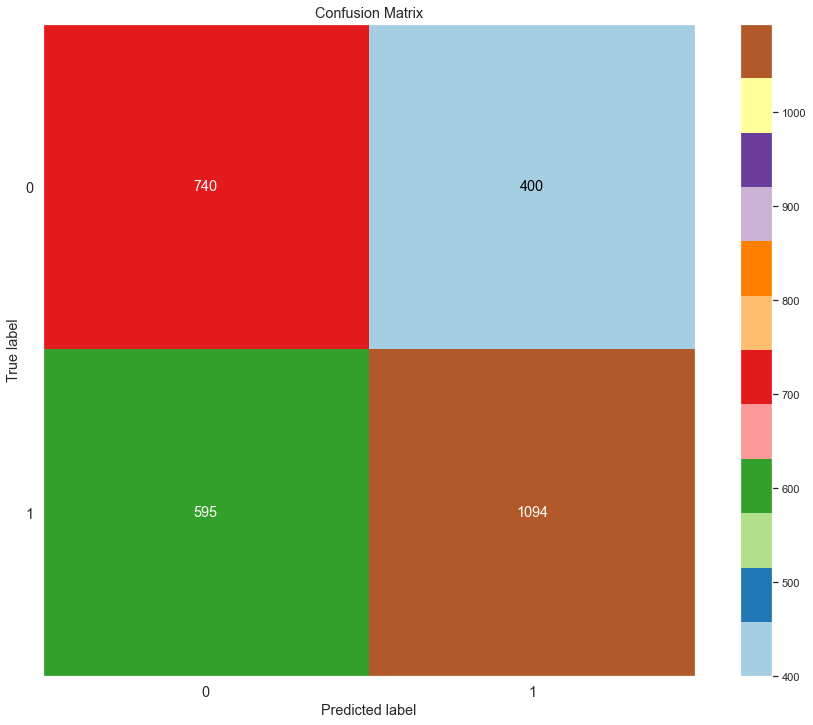

In [858]:
plot_utilities.plot_confusion_matrix(y_test, svc_pred, title='Confusion Matrix')

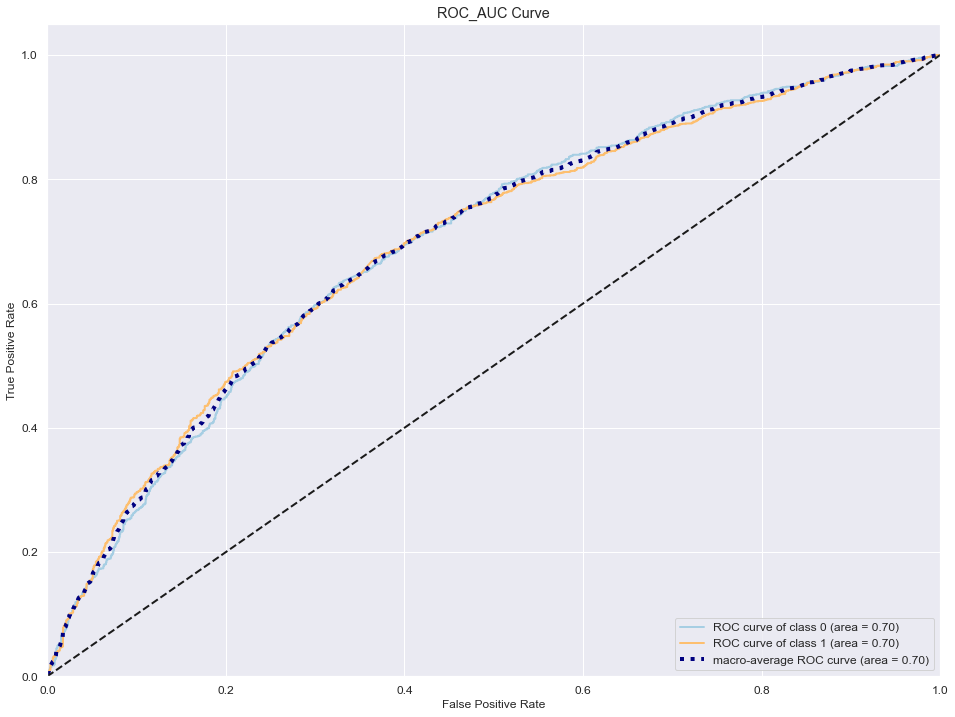

In [859]:
plot_utilities.plot_roc_auc_curve(y_test, svc_pred_prob, title='ROC_AUC Curve')

In [680]:
final_prediction_nba_log_regr = get_prediction_df(svc_pred_prob, svc_pred, nba_df)
final_prediction_nba_log_regr

,GAME_ID,H_NAME,A_NAME,SEASON,AWAY_WIN_PROBABILITY,HOME_WIN_PROBABILITY,RESULT_PREDICTION
8,21401081,HOU,MIN,2014,0.179623,0.820377,Home Team Win
14,21400636,GSW,HOU,2014,0.231338,0.768662,Home Team Win
15,21600491,LAL,DAL,2016,0.561541,0.438459,Away Team Win
19,21900882,MIL,OKC,2019,0.245734,0.754266,Home Team Win
31,21700264,PHX,MIL,2017,0.687340,0.312660,Away Team Win
...,...,...,...,...,...,...,...
14112,21800838,GSW,MIA,2018,0.177075,0.822925,Home Team Win
14127,21100381,NOP,CHI,2011,0.780295,0.219705,Away Team Win
14130,21801102,LAL,SAC,2018,0.723286,0.276714,Away Team Win
14138,21801023,TOR,LAL,2018,0.327814,0.672186,Home Team Win


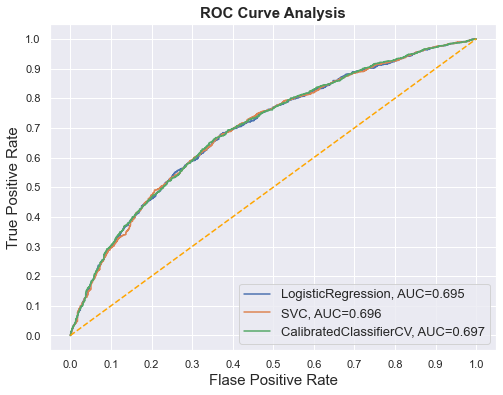

In [888]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
# Instantiate the classfiers and make a list
classifiers = [LogisticRegression(C=0.17, random_state=42,
                                  tol=0.6512956576760954),
               SVC(C=1.1725, cache_size=1800, degree=1, gamma=0.015, kernel='poly',
                   random_state=42, probability=True),
               CalibratedClassifierCV(LinearSVC(C=0.2594686288978597, dual=False, fit_intercept=False,
                         random_state=42, tol=0.8357856545225774))
               ]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(features_scaled, labels)
    yproba = model.predict_proba(X_test)[::,1]

    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)

    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr,
                                        'tpr':tpr,
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'],
             result_table.loc[i]['tpr'],
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))

plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()